In [111]:
import numpy as np
import pickle
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sys

from mutator_classes import Parameters
import stationary_distribution_aug as sd

sns.set_style('whitegrid')

In [112]:
# generate stationary distributions for different paramter values 
def get_phi(S,p_dict):
    return S/(4*p_dict['N']*p_dict['h']*p_dict['s']*p_dict['loci'])

param_string = "{--N=2000 --M=1000 --h=0.5 --s=0.01 --phi=1.0416666666666667e-09 --mutator_mutation_rate=1.25e-07 --mutation_rate=6.25e-08 --loci=24000000.0}"
p_dict = eval(param_string.replace('--',"'").replace('=',"':").replace(' ',', '))

results = {}
for S in np.logspace(-2,3,100):
    phi = get_phi(S=S,p_dict=p_dict)
    
    p_dict['phi'] = phi
    p = Parameters(**p_dict)
    results[S] = (sd.get_SD(p),phi)

In [113]:
# calculate relevant summary statistics from stationary distributions
def summarize_analytics(results):
    
    summaries = {}
    for S,(statdist,phi) in results.items():
        mean_freq = sum([p*q for p,q in statdist.items()])
        var_freq  = sum([p**2*q for p,q in statdist.items()]) - mean_freq**2
        within_freq = sum([p*(1-p)*q for p,q in statdist.items()])
        
        summaries[S] = (mean_freq,var_freq,within_freq,phi)
 
    return summaries

summarized_analytic_results = summarize_analytics(results)

In [122]:
# load the results from simulations
directory = '/Users/will_milligan/PycharmProjects/MUTATOR_FINAL/variableMutatorEffectResults'
files = os.listdir(directory)
results = {}
for f in files:
    if 'bin0_' in f: continue
    bin_n = eval(f.split('.')[0].split('bin')[-1])
    name = os.path.join(directory,f)
    with open(name,'rb') as fin:
        a = pickle.load(fin)
    results[bin_n] = a

In [123]:
# plotting instructions for between populations 
def variance_figure(ax,
                   results,
                   midpoints,
                   bin_width,
                   summarized_analytic_results = summarized_analytic_results,
                   scaling_factor = 1):
    
    plt.sca(ax)
    
    S_anal_x = np.array(list(summarized_analytic_results.keys()))
    S_anal_y = np.array([summarized_analytic_results[S][1]*(2*summarized_analytic_results[S][-1])**2 for S in S_anal_x])
    plt.plot(S_anal_x,S_anal_y/scaling_factor,color='k',alpha=0.5)

    for bin_n, a in results.items():

        mean,error,error2,analytic = a['var_rate']

        # correcting an error in processing results
        analytic = analytic - 3*a['mean_rate'][-1]**2
        xerr = np.reshape([midpoints[bin_n]-midpoints[bin_n]/bin_width,
                           midpoints[bin_n]*bin_width-midpoints[bin_n]],(2,1))
            
        plt.plot(midpoints[bin_n],
                 analytic/scaling_factor,
                 zorder=100,
                 **dict(marker='D', linestyle='None', markersize=5,
                           color='lightgrey',
                           markerfacecolor=[0,0,0,0],
                           markerfacecoloralt=[0,0,0,0],
                           markeredgecolor=[0,0,0,0.5]))
        
        plt.errorbar(midpoints[bin_n],
                         mean/scaling_factor,
                         yerr=error2/scaling_factor,
                         xerr=0*xerr,
                         color='k',
                         marker='.')

In [124]:
# plotting instructions for within populations 
def within_variance_figure(ax,
                           results,
                           midpoints,
                           bin_width,
                           scaling_factor = 1):
    plt.sca(ax)

    S_anal_x = np.array(list(summarized_analytic_results.keys()))
    S_anal_y = np.array([2*summarized_analytic_results[S][2]*(summarized_analytic_results[S][-1])**2 for S in S_anal_x])
    plt.plot(S_anal_x,S_anal_y/scaling_factor,color='r',alpha=0.5)
    
    for bin_n, a in results.items():
        
        mean,error,error2,analytic = a['within_rate']
        xerr = np.reshape([midpoints[bin_n]-midpoints[bin_n]/bin_width,
                           midpoints[bin_n]*bin_width-midpoints[bin_n]],(2,1))
            
        plt.plot(midpoints[bin_n],
                 analytic/scaling_factor,
                 zorder=100,
                 **dict(marker='D', linestyle='None', markersize=5,
                           color='lightgrey',
                           markerfacecolor=[0,0,0,0],
                           markerfacecoloralt=[0,0,0,0],
                           markeredgecolor=[1,0,0,0.5]))

        plt.errorbar(midpoints[bin_n],
                     mean/scaling_factor,
                     yerr=error2/scaling_factor,
                     xerr=0*xerr,
                     color='r',
                     marker='.')

    plt.text(x=0.75e-2,y = 0.75e-7*1.25e-7**2,rotation = 55,s='Between',color='k')
    plt.text(x=0.75e-2,y = 0.75e-10*1.25e-7**2,rotation = 55,s='Within',color='r')
    plt.yscale('log')
    plt.xscale('log')
    plt.xticks(np.logspace(-2,3,6))
    plt.xlabel(r'Scaled selection parameter $(4NLhs\phi$)',size = 10)
    plt.ylabel(r'Variance from single modifier site')
    plt.title(r'$\bf{B.}$ Variance in mutation rate',size=10)

In [125]:
# Plotting instructions for mean figure

def mean_figure(ax,
               results,
               midpoints,
               bin_width,
               summarized_analytic_results = summarized_analytic_results,
               scaling_factor = 1):
    
    plt.sca(ax)

    # calculate and plot analytic curve
    S_anal_x = np.array(list(summarized_analytic_results.keys()))
    S_anal_y = np.array([summarized_analytic_results[S][0]*2*summarized_analytic_results[S][-1] for S in S_anal_x])
    plt.plot(S_anal_x,S_anal_y/scaling_factor,color='k',alpha=0.5,label='Analytic\n'+'approx.')
    
    # just for the legend
    plt.plot([],[],
             zorder=100,
             label = 'Analytic\n'+'mean per bin',
                 **dict(marker='D', linestyle='None', markersize=5,
                           color='lightgrey',
                           markerfacecolor=[0,0,0,0],
                           markerfacecoloralt=[0,0,0,0],
                           markeredgecolor=[0,0,0,0.5]))
    
    # plot simulation results
    for bin_n, a in results.items():
        # unpack the simulated mean and error along with the analytic mean from realized values of phi
        mean,error,error2,analytic = a['mean_rate']
        
        # correcting an error in processing results
        analytic = 2*analytic
        xerr = np.reshape([midpoints[bin_n]-midpoints[bin_n]/bin_width,
                           midpoints[bin_n]*bin_width-midpoints[bin_n]],(2,1))

        # plot analytic mean per bin
        plt.plot(midpoints[bin_n],
                 analytic/scaling_factor,
                 zorder=100,
                 **dict(marker='D', linestyle='None', markersize=5,
                           color='lightgrey',
                           markerfacecolor=[0,0,0,0],
                           markerfacecoloralt=[0,0,0,0],
                           markeredgecolor=[0,0,0,0.5]))
        
        # plot simulated mean and error
        if bin_n == 0:
            
            plt.errorbar(midpoints[bin_n],
                         mean/scaling_factor,
                         yerr=error2/scaling_factor,
                         color='k',
                         ls='None',
                         marker='.',
                         label = 'Simulated\n'+r'mean $\pm 2$ SEs')

        else:        

            plt.errorbar(midpoints[bin_n],
                         mean/scaling_factor,
                         yerr=error2/scaling_factor,
                         color='k',
                         ls='None',
                         marker='.')

    # add legend and do other plotting stuff
    plt.legend(loc='lower left',
               edgecolor='k',
               framealpha=1,
               handlelength = 1,
               handletextpad = 0.4,
               borderaxespad = 0.5,
               borderpad = 0.2,
               fontsize = 9)
    plt.yscale('log')
    plt.xscale('log')
    plt.xticks(np.logspace(-2,3,6))
    plt.ylim([5e-13,4e-10])
    plt.xlabel(r'Scaled selection parameter $(4NLhs\phi$)',size=10)
    plt.ylabel(r'Mean increase from single modifier site',size=10)
    plt.title(r'$\bf{A.}$ Expected mutation rate',size=10)

1.1313859628982916
0.18018646848961367
0.18565528926333225
0.04120403801293811
0.018221597321385143
0.11521316390381064
0.16362193326197477
0.2916164438655048
0.023637466367676302
0.019527263856155743


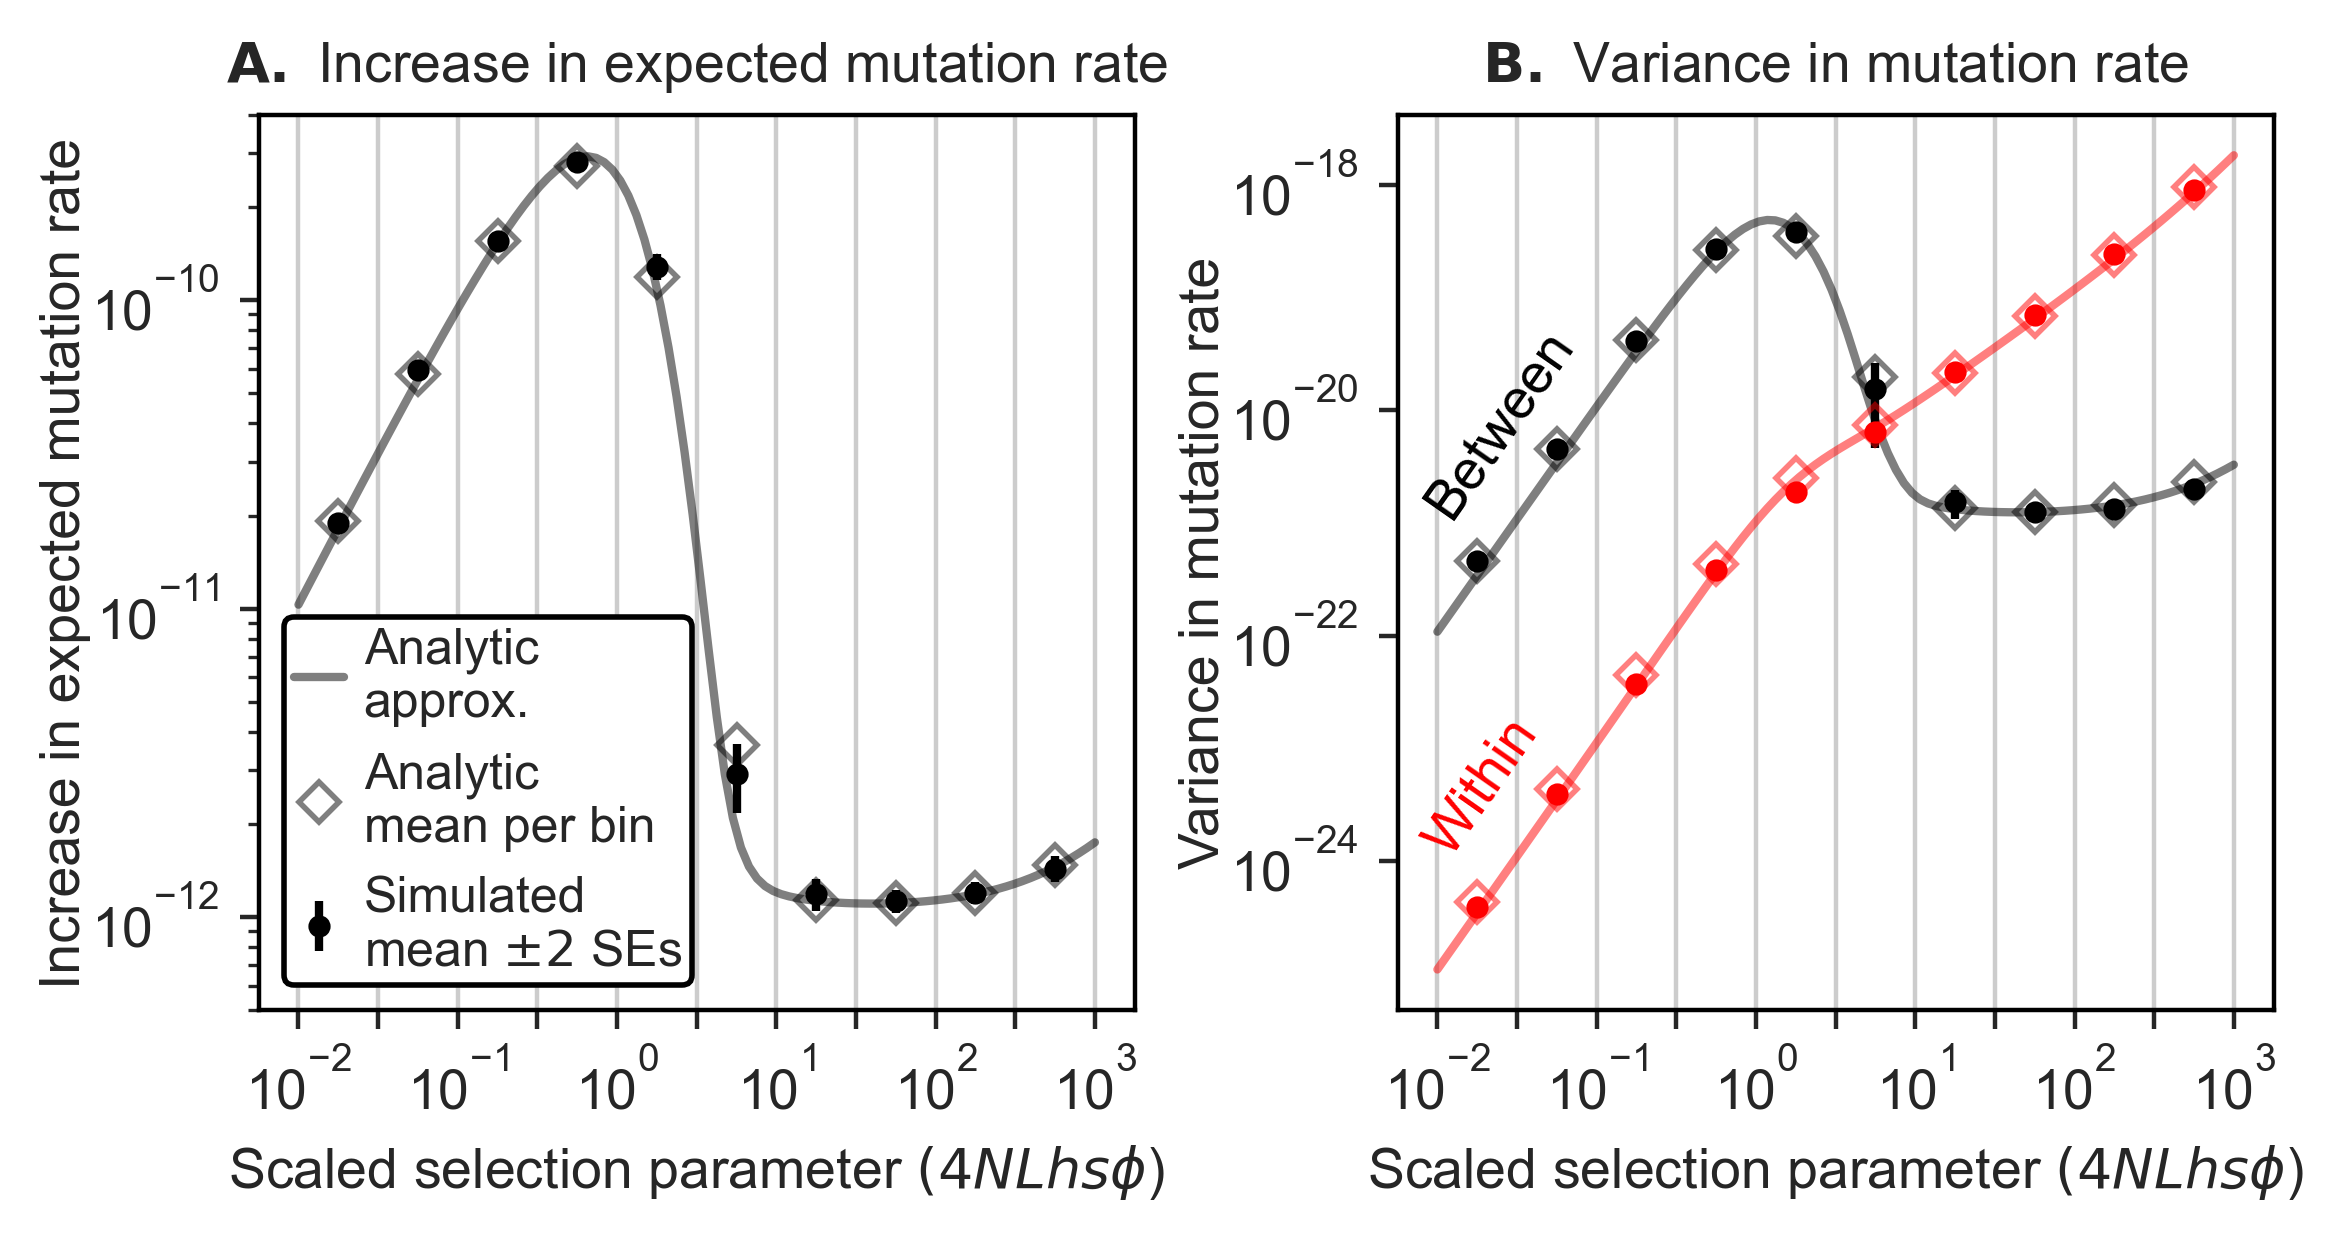

In [126]:
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 400
font_size = 10
mpl.rcParams['axes.titlesize'] = font_size
mpl.rcParams['axes.labelsize'] = font_size
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['legend.fontsize'] = font_size
mpl.rcParams['legend.title_fontsize'] = font_size

# calculate where the bins where
bin_windows = np.logspace(-2,3,11)
midpoints = [i for i in np.logspace(-2,3,21) if i not in bin_windows]
bin_width = np.mean(np.logspace(-2,3,21)[1:]/np.logspace(-2,3,21)[0:-1])

figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(6.5,3.65*6.5/8),dpi=400)

mean_figure(ax = ax1,
            results = results,
            midpoints = midpoints,
            bin_width = bin_width)

variance_figure(ax = ax2,
            results = results,
            midpoints = midpoints,
            bin_width = bin_width)

within_variance_figure(ax = ax2,
            results = results,
            midpoints = midpoints,
            bin_width = bin_width)

for ax in (ax1,ax2):
    ax.tick_params(bottom=True,left=True,labelbottom=True,labelleft=True,which='both')
    for spine in ax.spines.values():
        spine.set_color('k')
    ax.set_xticks(np.logspace(-2,3,11))
    ax.grid(False,axis='y')
        
ax1.set_ylabel(r'Increase in expected mutation rate',size=10,labelpad=0)
ax1.set_title(r'$\bf{A.}$ Increase in expected mutation rate',size=10)
ax2.set_ylabel('Variance in mutation rate',size=10,labelpad=0)
ax2.set_title(r'$\bf{B.}$ Variance in mutation rate',size=10)
plt.subplots_adjust(wspace=0.3)

In [ ]:
print()